In [2]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

In [20]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'

In [21]:
x = torch.linspace(-1, 1, 100)
f = lambda x: 3*x + 1 

noise = torch.distributions.Normal(0, 0.1).sample((100,))
y = f(x) + noise

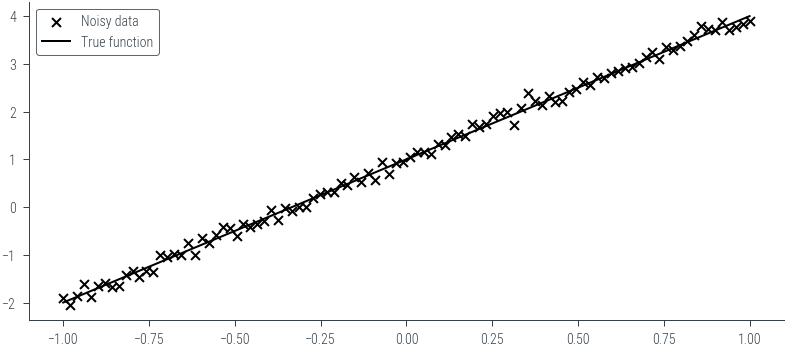

In [22]:
plt.scatter(x, y, marker='x', c='k', s=20, label="Noisy data")
plt.plot(x, f(x), c='k', label="True function")
plt.legend()

In [23]:
def forward(x, theta):
    return x*theta[1] + theta[0]

In [24]:
def nll(theta):
    mu = forward(x, theta)
    sigma = torch.tensor(1.0)
    dist = torch.distributions.normal.Normal(mu, sigma)
    return -dist.log_prob(y).sum()

In [25]:
nll(torch.zeros(2)), nll(torch.tensor([1., 3.]))

(tensor(297.3265), tensor(92.3937))

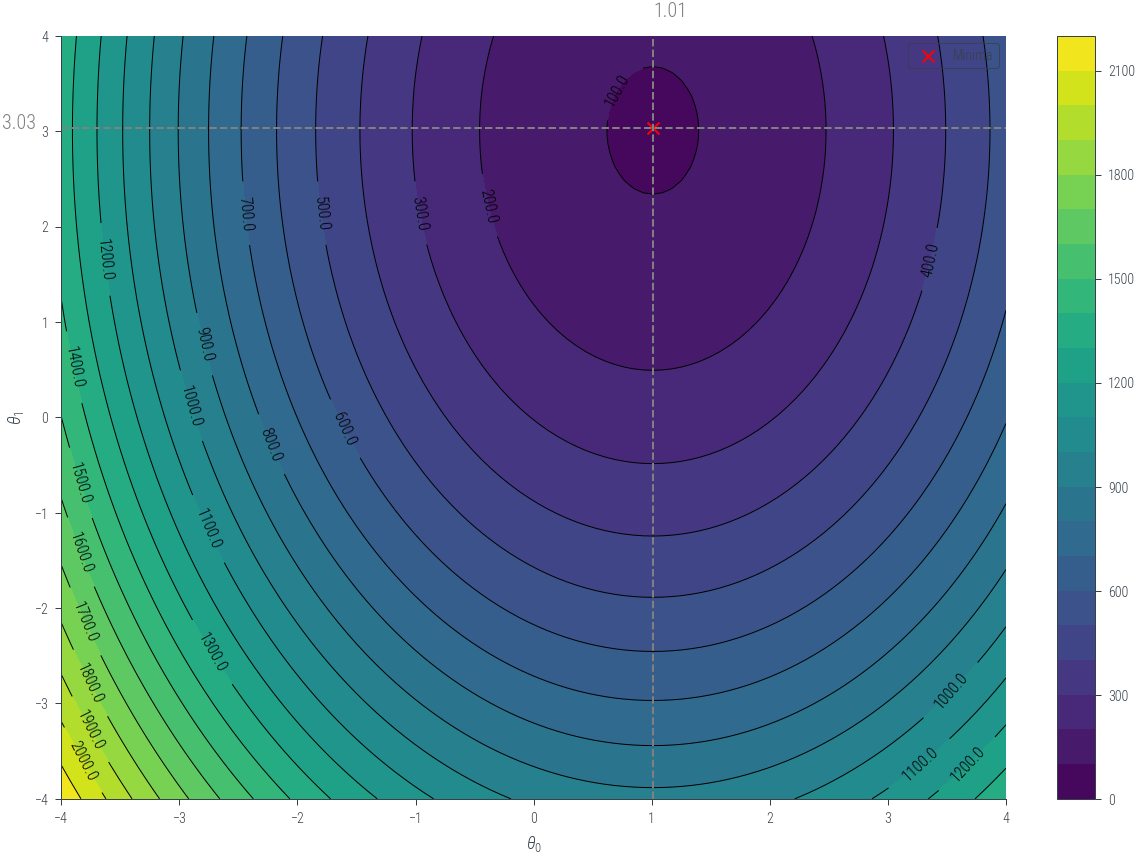

In [26]:
# Create a grid of theta[0] and theta[1] values
theta0_values = torch.linspace(-4, 4, 100)
theta1_values = torch.linspace(-4, 4, 100)
theta0_mesh, theta1_mesh = torch.meshgrid(theta0_values, theta1_values)
nll_values = torch.zeros_like(theta0_mesh)

# Calculate negative log-likelihood values for each combination of theta[0] and theta[1]
for i in range(len(theta0_values)):
    for j in range(len(theta1_values)):
        nll_values[i, j] = nll([theta0_values[i], theta1_values[j]])

# Create a contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(theta0_mesh, theta1_mesh, nll_values, levels=20, cmap='viridis')
plt.colorbar(contour)
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
#plt.title('Contour Plot of Negative Log-Likelihood')

# Adding contour level labels
contour_labels = plt.contour(theta0_mesh, theta1_mesh, nll_values, levels=20, colors='black', linewidths=0.5)
plt.clabel(contour_labels, inline=True, fontsize=8, fmt='%1.1f')

# Find and mark the minimum
min_indices = torch.argmin(nll_values)
min_theta0 = theta0_mesh.flatten()[min_indices]
min_theta1 = theta1_mesh.flatten()[min_indices]
plt.scatter(min_theta0, min_theta1, color='red', marker='x', label='Minima')

# Draw lines from the minimum point to the axes
plt.axhline(min_theta1, color='gray', linestyle='--')
plt.axvline(min_theta0, color='gray', linestyle='--')

# Add labels to the lines
plt.text(min_theta0, 4.2, f'{min_theta0:.2f}', color='gray', fontsize=10)
plt.text(-4.5, min_theta1, f'{min_theta1:.2f}', color='gray', fontsize=10)
plt.legend()

In [27]:

def plot_theta(theta):
    plt.figure(figsize=(8, 4))

    # Left-hand side plot (contour plot)
    plt.subplot(1, 2, 1)
    contour = plt.contourf(theta0_mesh, theta1_mesh, nll_values, levels=20, cmap='viridis')
    # Colorbar
    plt.colorbar(contour)
    plt.scatter(theta[0], theta[1], color='red', marker='x')
    plt.axhline(theta[1], color='gray', linestyle='--')
    plt.axvline(theta[0], color='gray', linestyle='--')
    plt.xlabel(r'$\theta_0$')
    plt.ylabel(r'$\theta_1$')
    plt.title('Contour Plot of Negative Log-Likelihood')

    # Right-hand side plot (data fit)
    plt.subplot(1, 2, 2)
    plt.scatter(x, y, label='Data')
    plt.plot(x, theta[0] + theta[1] * x, color='red', label='Fit')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Data Fit')
    plt.legend()

    #plt.tight_layout()
    plt.show()

# Generate a random theta vector
random_theta = torch.randn(2)
print(random_theta)

import ipywidgets as widgets
from ipywidgets import interact


@interact(theta0=(-5, 5, 0.1), theta1=(-5, 5, 0.1))
def plot_interactive(theta0=random_theta[0], theta1=random_theta[1]):
    theta = [theta0, theta1]
    plot_theta(theta)


tensor([-0.9771,  0.4177])


interactive(children=(FloatSlider(value=-0.977085292339325, description='theta0', max=5.0, min=-5.0), FloatSli…

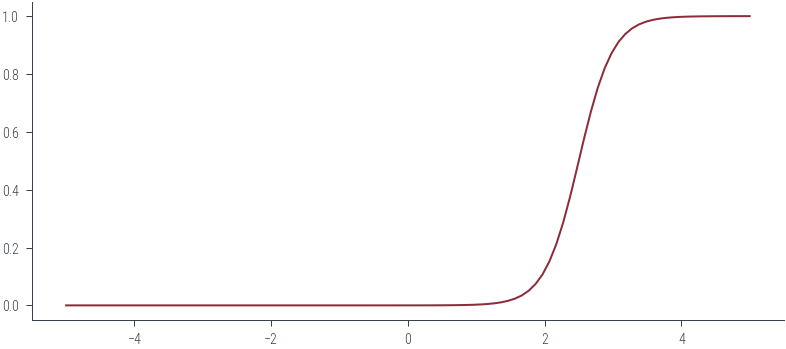

In [39]:
## Logistic regression

x = torch.linspace(-5, 5, 100)

true_theta = torch.tensor([-10.0, 4.0])
p = torch.sigmoid(true_theta[0] + true_theta[1] * x)

plt.plot(x, p, label='p(x)')

In [42]:
y = torch.distributions.Bernoulli(probs=p).sample()
y

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

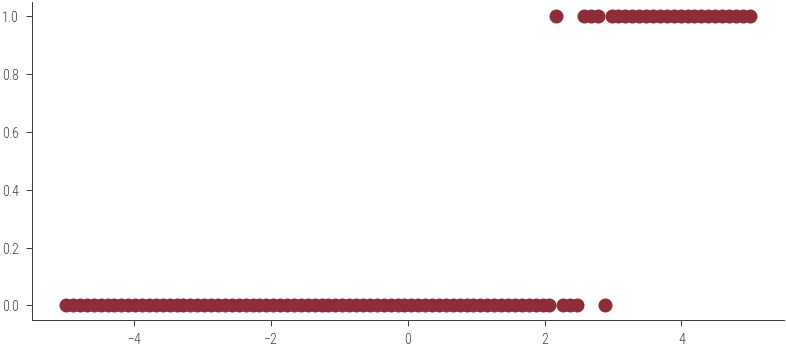

In [43]:
plt.plot(x, y, 'o')

In [47]:
def nll_lr(theta):
    p = torch.sigmoid(theta[0]+ theta[1]*x)
    dist = torch.distributions.Bernoulli(probs=p)
    return -dist.log_prob(y).sum()

def nll_lr_logits(theta):
    logits = theta[0]+ theta[1]*x
    dist = torch.distributions.Bernoulli(logits=logits)
    return -dist.log_prob(y).sum()


In [48]:
nll_lr(torch.tensor([1.0, 1.0])), nll_lr(true_theta), nll_lr_logits(torch.tensor([1.0, 1.0])), nll_lr_logits(true_theta), 

(tensor(78.3085), tensor(6.8952), tensor(78.3085), tensor(6.8952))

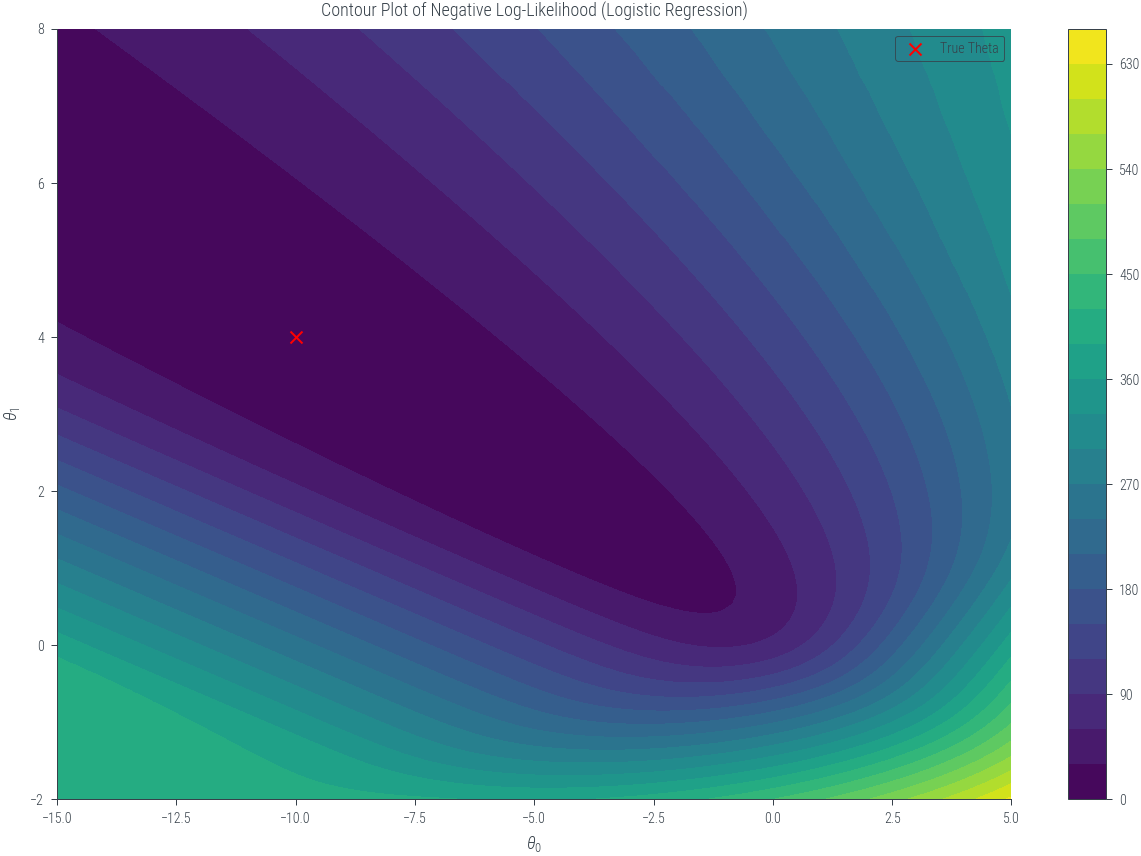

In [46]:
# Create a grid of theta[0] and theta[1] values
theta0_values = torch.linspace(-15, 5, 100)
theta1_values = torch.linspace(-2, 8, 100)
theta0_mesh, theta1_mesh = torch.meshgrid(theta0_values, theta1_values)
nll_values = torch.zeros_like(theta0_mesh)

# Calculate negative log-likelihood values for each combination of theta[0] and theta[1]
for i in range(len(theta0_values)):
    for j in range(len(theta1_values)):
        nll_values[i, j] = nll_lr([theta0_values[i], theta1_values[j]])

# Create a contour plot
plt.figure(figsize=(8, 6))
contour = plt.contourf(theta0_mesh, theta1_mesh, nll_values, levels=20, cmap='viridis')
plt.colorbar(contour)
plt.scatter(true_theta[0], true_theta[1], color='red', marker='x', label='True Theta')
plt.xlabel(r'$\theta_0$')
plt.ylabel(r'$\theta_1$')
plt.title('Contour Plot of Negative Log-Likelihood (Logistic Regression)')
plt.legend()


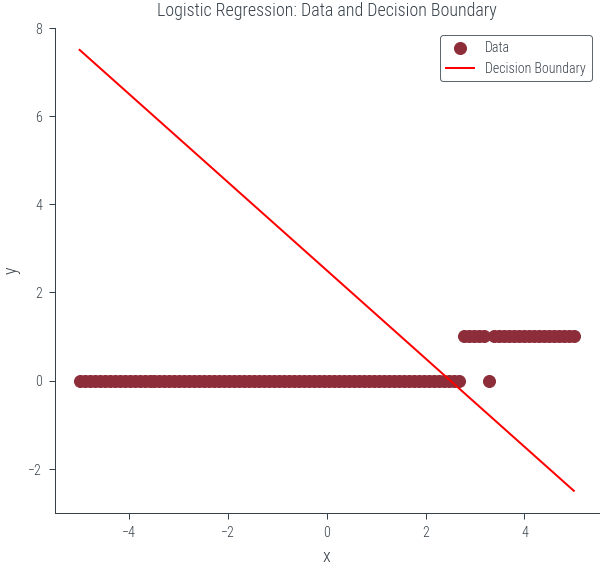

In [16]:
def decision_boundary(theta):
    return - (theta[0] + theta[1] * x) / theta[1]

# Create a given theta vector
given_theta = torch.tensor([-10.0, 4.0])

# Plot data and decision boundary for the given theta
plt.figure(figsize=(8, 4))

# Left-hand side plot (data and decision boundary)
plt.subplot(1, 2, 1)
plt.scatter(x, y, label='Data')
plt.plot(x, decision_boundary(given_theta), color='red', label='Decision Boundary')
plt.xlabel('x')
plt.ylabel('y')
plt.title('Logistic Regression: Data and Decision Boundary')
plt.legend()